In [1]:
import os
import glob
from random import shuffle
from tqdm import tqdm

import torch.nn as nn
import torch.functional as F
import torchvision.models as models

from fastai.vision import *
from fastai.metrics import error_rate

import matplotlib.pyplot as plt
%matplotlib inline

# Load some test data

In [2]:
test_sample = np.load('data/training_data-1.npy', allow_pickle=True)
test_img = test_sample[0][0]
test_controls = test_sample[0][1]
print(test_img.shape)
print(test_controls)

(270, 480, 3)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


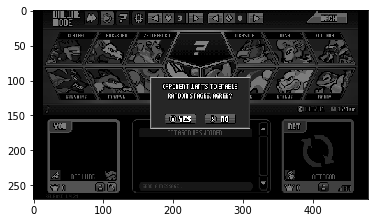

In [3]:
plt.imshow(test_img)

# Loss Function

In [4]:
# TORCH IMPLEMENTATION - WILL BE USED ONCE I REFACTOR THE NETWORK AND TRAINING LOOP INTO TORCH
# def customized_loss(y_true, y_pred, loss='euclidean'):
#     if loss == 'L2':
#         L2_norm_cost = 0.001
#         val = torch.mean(((y_pred - y_true)**2), axis=-1) + sum(y_pred**2)/2 * L2_norm_cost
#     # Euclidean distance loss
#     elif loss == 'euclidean':
#         val = torch.sqrt(torch.sum((torch.FloatTensor(y_pred) - torch.FloatTensor(y_true)**2)))
#         return val

In [5]:
def customized_loss(y_true, y_pred, loss='euclidean'):
    # Simply a mean squared error that penalizes large joystick summed values
    if loss == 'L2':
        L2_norm_cost = 0.001
        val = K.mean(K.square((y_pred - y_true)), axis=-1) \
                    + K.sum(K.square(y_pred), axis=-1)/2 * L2_norm_cost
    # euclidean distance loss
    elif loss == 'euclidean':
        val = K.sqrt(K.sum(K.square(y_pred-y_true), axis=-1))
    return val

# Constants

In [6]:
FILE_I_END = 107

EPOCHS = 30

INPUT_SHAPE = test_img.shape
DIMENSION = INPUT_SHAPE[2]
WIDTH = INPUT_SHAPE[1]
HEIGHT = INPUT_SHAPE[0]

OUT_SHAPE = 10 # Vector of len 10 where each element is a value for a control output

print('Shape: ', INPUT_SHAPE)
print('Width: ', WIDTH)
print('Height:', HEIGHT)

Shape:  (270, 480, 3)
Width:  480
Height: 270


# Simple Network

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras import optimizers
from keras import backend as K
from utils import Sample

# Global variable
OUT_SHAPE = 5
INPUT_SHAPE = (HEIGHT, WIDTH, DIMENSION)
MODEL_NAME = 'test_model_v1'


def create_model(keep_prob = 0.8):
    model = Sequential()

    # NVIDIA's model
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape= INPUT_SHAPE))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    drop_out = 1 - keep_prob
    model.add(Dropout(drop_out))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(OUT_SHAPE, activation='softsign'))

    return model

Using TensorFlow backend.


we found a gamepad.


In [8]:
# Handy function to properly sort files
def order_files_by_date(path_to_folder, file_type):
    files = glob.glob("%s*%s" % (path_to_folder, file_type))
    files.sort(key=os.path.getmtime)
    return files

In [9]:
data_files = order_files_by_date('data/', '.npy')
shuffle(data_files) # Make sure the files appear in random order
print(f'There are {len(data_files)} files in "data/" folder')

There are 107 files in "data/" folder


In [ ]:
model = create_model()
model.compile(loss=customized_loss, optimizer=optimizers.adam())
BATCH_SIZE = 50

for e in range(EPOCHS):
    for i, file in enumerate(data_files):
        try:
            data = np.load(file, allow_pickle=True)
            
            train = data[:-50]
            test = data[-50:]
            
            X = np.array([i[0] for i in train]).reshape(-1,WIDTH,HEIGHT,3)
            Y = [i[1] for i in train]

            test_x = np.array([i[0] for i in test]).reshape(-1,WIDTH,HEIGHT,3)
            test_y = [i[1] for i in test]
            
            
#             model.fit(X, Y, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True, validation_split=0.1)
            model.fit({'input': X}, {'targets': Y}, n_epoch=1, validation_set=({'input': test_x}, {'targets': test_y}), 
                snapshot_step=2500, show_metric=True, run_id=MODEL_NAME)
            
            model.save_weights('test_model.h5')
            
        except Exception as e:
            print(str(e))

Unrecognized keyword arguments: {'n_epoch': 1, 'validation_set': ({'input': array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [175, 175, 175],
         [175, 175, 175],
         [175, 175, 175],
         [175, 175, 175]],

        [[175, 175, 175],
         [175, 175, 175],
         [175, 175, 175],
         [175, 175, 175],
         ...,
         [ 46,  46,  46],
         [  0,   0,   0],
         [168, 168, 168],
         [ 10,  10,  10]],

        [[ 10,  10,  10],
         [158, 158, 158],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [252, 252, 252],
         [255, 255, 255],
         [255, 255, 255],
         [239, 239, 239]],

        [[255, 255, 255],
         [255, 255, 255],
         [239, 239, 239],
         [255, 255, 255],
         ...,
         [ 48,  48,  48],
         [ 48,  48,  48],
         [ 48,  48,  48],
         [ 48,  48,  48]],

        ...,

        [[185,

In [ ]:
if __name__ == '__main__':
    # Load Training Data
    x_train = np.load("data/X.npy")
    y_train = np.load("data/y.npy")

    print(x_train.shape[0], 'train samples')

    # Training loop variables
    epochs = 100
    batch_size = 50

    model = create_model()
    model.compile(loss=customized_loss, optimizer=optimizers.adam())
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1)

    model.save_weights('model_weights.h5')